# 02. Baseline Models Implementation

## Objective
Implement baseline models to establish a performance floor and demonstrate that ML models add value over simple heuristics.

## Baseline Strategies
1. **Random Guess**: 33.3% accuracy (3 classes)
2. **Majority Class**: Predict most common class
3. **Persistence Model**: Predict that future trajectory = current trajectory
4. **Simple Rule-Based**: Use simple thresholds on key features


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported")


✅ Libraries imported


## 1. Load Data


In [2]:
# Load the dataset
df = pd.read_csv('../today/trajectory_ml_ready_advanced.csv')

# Prepare features and target
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']
X = df.drop(columns=drop_cols)
y = df['Target_Label'].astype(int)

# One-hot encode Division
X = pd.get_dummies(X, columns=['Division'], drop_first=True)

# Split data (using same random state as original model for comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")
print(f"\nClass Distribution (Train):")
print(y_train.value_counts().sort_index())
print(f"\nClass Distribution (Test):")
print(y_test.value_counts().sort_index())


Training Set: 9643 samples
Test Set: 2411 samples

Class Distribution (Train):
Target_Label
0    3775
1    4555
2    1313
Name: count, dtype: int64

Class Distribution (Test):
Target_Label
0     944
1    1139
2     328
Name: count, dtype: int64


## 2. Baseline 1: Random Guess


In [3]:
# Random guess: predict each class with equal probability
np.random.seed(42)
y_pred_random = np.random.choice([0, 1, 2], size=len(y_test))

accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"Random Guess Accuracy: {accuracy_random:.4f} ({accuracy_random*100:.2f}%)")
print(f"Expected: ~33.33% for 3 classes")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_random, 
                          target_names=['Declining', 'Stable', 'Improving']))


Random Guess Accuracy: 0.3202 (32.02%)
Expected: ~33.33% for 3 classes

Classification Report:
              precision    recall  f1-score   support

   Declining       0.37      0.33      0.35       944
      Stable       0.44      0.31      0.37      1139
   Improving       0.14      0.33      0.19       328

    accuracy                           0.32      2411
   macro avg       0.32      0.32      0.30      2411
weighted avg       0.37      0.32      0.34      2411



## 3. Baseline 2: Majority Class


In [4]:
# Predict the most common class in training data
majority_class = y_train.mode()[0]
y_pred_majority = np.full(len(y_test), majority_class)

accuracy_majority = accuracy_score(y_test, y_pred_majority)
print(f"Majority Class: {majority_class} ({'Declining' if majority_class == 0 else 'Stable' if majority_class == 1 else 'Improving'})")
print(f"Majority Class Accuracy: {accuracy_majority:.4f} ({accuracy_majority*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_majority, 
                          target_names=['Declining', 'Stable', 'Improving']))


Majority Class: 1 (Stable)
Majority Class Accuracy: 0.4724 (47.24%)

Classification Report:
              precision    recall  f1-score   support

   Declining       0.00      0.00      0.00       944
      Stable       0.47      1.00      0.64      1139
   Improving       0.00      0.00      0.00       328

    accuracy                           0.47      2411
   macro avg       0.16      0.33      0.21      2411
weighted avg       0.22      0.47      0.30      2411



/Users/mukeshravichandran/ML EDA/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mukeshravichandran/ML EDA/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mukeshravichandran/ML EDA/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

## 4. Baseline 3: Persistence Model


In [5]:
# Persistence: predict that future trajectory = current trajectory
# This requires knowing the current trajectory for each test sample

# Load full dataset to get current trajectory
df_full = pd.read_csv('../today/trajectory_ml_ready_advanced.csv')
df_full['Target_Label'] = df_full['Target_Label'].astype(int)

# For each test sample, find its current trajectory
# We need to match by UNITID and Year
test_indices = y_test.index
y_pred_persistence = []

for idx in test_indices:
    # Get the row from full dataset
    row = df_full.iloc[idx]
    unitid = row['UNITID']
    year = row['Year']
    
    # Find the same institution in previous year
    prev_year_data = df_full[(df_full['UNITID'] == unitid) & (df_full['Year'] == year - 1)]
    
    if not prev_year_data.empty:
        # Use previous year's trajectory as prediction
        prev_trajectory = prev_year_data.iloc[0]['Target_Label']
        y_pred_persistence.append(prev_trajectory)
    else:
        # If no previous year, use majority class
        y_pred_persistence.append(majority_class)

y_pred_persistence = np.array(y_pred_persistence)

accuracy_persistence = accuracy_score(y_test, y_pred_persistence)
print(f"Persistence Model Accuracy: {accuracy_persistence:.4f} ({accuracy_persistence*100:.2f}%)")
print("(Predicts that future trajectory = current trajectory)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_persistence, 
                          target_names=['Declining', 'Stable', 'Improving']))


Persistence Model Accuracy: 0.4616 (46.16%)
(Predicts that future trajectory = current trajectory)

Classification Report:
              precision    recall  f1-score   support

   Declining       0.40      0.36      0.38       944
      Stable       0.56      0.64      0.60      1139
   Improving       0.16      0.13      0.14       328

    accuracy                           0.46      2411
   macro avg       0.38      0.38      0.37      2411
weighted avg       0.45      0.46      0.45      2411



## 5. Baseline 4: Simple Rule-Based Model


In [6]:
# Simple rule: Use key features to make predictions
# Rules based on domain knowledge:
# - If revenue growth is high and efficiency is good → Improving
# - If revenue is declining or expenses growing fast → Declining
# - Otherwise → Stable

def simple_rule_predict(row):
    """Simple rule-based prediction"""
    # Get key features
    revenue_growth = row.get('Revenue_Growth_1yr', 0)
    expense_growth = row.get('Expense_Growth_1yr', 0)
    efficiency = row.get('Efficiency_Mean_2yr', 1.0)
    
    # Rule 1: Improving - High revenue growth and good efficiency
    if revenue_growth > 0.05 and efficiency > 1.0:
        return 2  # Improving
    
    # Rule 2: Declining - Negative revenue growth OR expenses growing much faster
    if revenue_growth < -0.02 or (expense_growth - revenue_growth) > 0.05:
        return 0  # Declining
    
    # Rule 3: Default to Stable
    return 1  # Stable

# Apply rules to test set
y_pred_rules = X_test.apply(simple_rule_predict, axis=1).values

accuracy_rules = accuracy_score(y_test, y_pred_rules)
print(f"Simple Rule-Based Accuracy: {accuracy_rules:.4f} ({accuracy_rules*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rules, 
                          target_names=['Declining', 'Stable', 'Improving']))


Simple Rule-Based Accuracy: 0.4455 (44.55%)

Classification Report:
              precision    recall  f1-score   support

   Declining       0.39      0.30      0.34       944
      Stable       0.58      0.60      0.59      1139
   Improving       0.22      0.35      0.27       328

    accuracy                           0.45      2411
   macro avg       0.40      0.41      0.40      2411
weighted avg       0.46      0.45      0.45      2411



## 6. Compare All Baselines


BASELINE MODELS COMPARISON
      Baseline  Accuracy
  Random Guess  0.320199
Majority Class  0.472418
   Persistence  0.461634
  Simple Rules  0.445458

✅ Best Baseline: Majority Class with 0.4724 accuracy


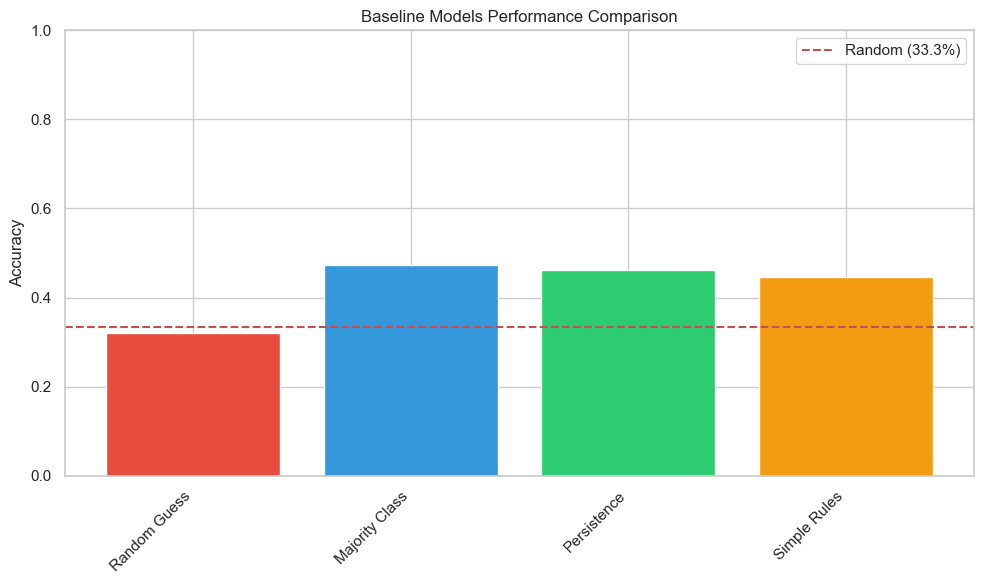


📊 Chart saved as 'baseline_comparison.png'


In [7]:
# Create comparison table
baseline_results = {
    'Baseline': ['Random Guess', 'Majority Class', 'Persistence', 'Simple Rules'],
    'Accuracy': [accuracy_random, accuracy_majority, accuracy_persistence, accuracy_rules],
    'Predictions': [y_pred_random, y_pred_majority, y_pred_persistence, y_pred_rules]
}

baseline_df = pd.DataFrame({
    'Baseline': baseline_results['Baseline'],
    'Accuracy': baseline_results['Accuracy']
})

print("=" * 60)
print("BASELINE MODELS COMPARISON")
print("=" * 60)
print(baseline_df.to_string(index=False))

# Find best baseline
best_baseline_idx = baseline_df['Accuracy'].idxmax()
best_baseline = baseline_df.iloc[best_baseline_idx]
print(f"\n✅ Best Baseline: {best_baseline['Baseline']} with {best_baseline['Accuracy']:.4f} accuracy")

# Visualize
plt.figure(figsize=(10, 6))
bars = plt.bar(baseline_df['Baseline'], baseline_df['Accuracy'], 
               color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])
plt.axhline(y=0.333, color='r', linestyle='--', label='Random (33.3%)')
plt.ylabel('Accuracy')
plt.title('Baseline Models Performance Comparison')
plt.ylim(0, 1)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Chart saved as 'baseline_comparison.png'")


## 7. Compare with ML Model Performance


ML MODEL vs BASELINES
         Model  Accuracy  ROC-AUC
  Random Guess  0.320199      NaN
Majority Class  0.472418      NaN
   Persistence  0.461634      NaN
  Simple Rules  0.445458      NaN
  XGBoost (ML)  0.554127 0.764665

📈 ML Model Improvement:
   Best Baseline: 0.4724
   ML Model: 0.5541
   Improvement: +0.0817 (+17.30%)
   ROC-AUC: 0.7647


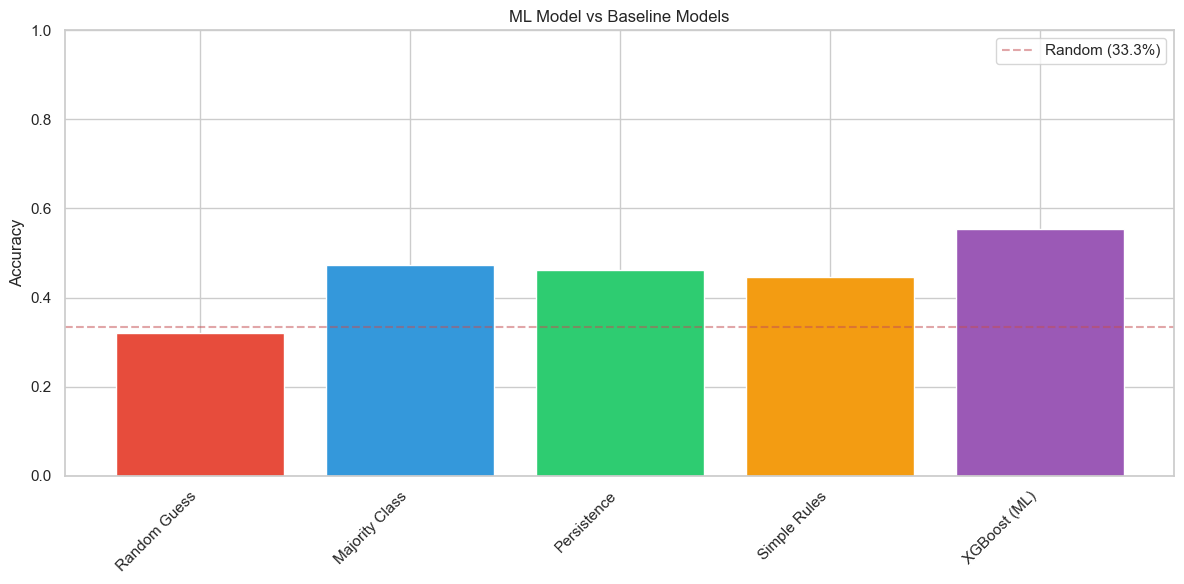

In [9]:
# Load the saved ML model to compare
import joblib

try:
    ml_model = joblib.load('../today/models/final_trajectory_model.joblib')

    # Recreate raw feature split so the pipeline sees the expected columns (Division, etc.)
    drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']
    X_raw = df.drop(columns=drop_cols)
    X_train_raw, X_test_raw, _, _ = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42
    )

    # Get predictions from ML model (preprocessing handled internally)
    y_pred_ml = ml_model.predict(X_test_raw)
    y_prob_ml = ml_model.predict_proba(X_test_raw)

    accuracy_ml = accuracy_score(y_test, y_pred_ml)

    # Calculate ROC-AUC
    try:
        roc_auc_ml = roc_auc_score(y_test, y_prob_ml, multi_class='ovr')
    except:
        roc_auc_ml = None

    print("=" * 60)
    print("ML MODEL vs BASELINES")
    print("=" * 60)

    comparison = pd.DataFrame({
        'Model': ['Random Guess', 'Majority Class', 'Persistence', 'Simple Rules', 'XGBoost (ML)'],
        'Accuracy': [accuracy_random, accuracy_majority, accuracy_persistence, accuracy_rules, accuracy_ml]
    })

    if roc_auc_ml:
        comparison['ROC-AUC'] = [None, None, None, None, roc_auc_ml]

    print(comparison.to_string(index=False))

    # Calculate improvement over best baseline
    best_baseline_acc = max(accuracy_random, accuracy_majority, accuracy_persistence, accuracy_rules)
    improvement = accuracy_ml - best_baseline_acc
    improvement_pct = (improvement / best_baseline_acc) * 100

    print(f"\n📈 ML Model Improvement:")
    print(f"   Best Baseline: {best_baseline_acc:.4f}")
    print(f"   ML Model: {accuracy_ml:.4f}")
    print(f"   Improvement: +{improvement:.4f} ({improvement_pct:+.2f}%)")

    if roc_auc_ml:
        print(f"   ROC-AUC: {roc_auc_ml:.4f}")

    # Visualize comparison
    plt.figure(figsize=(12, 6))
    models = comparison['Model'].values
    accuracies = comparison['Accuracy'].values

    bars = plt.bar(models, accuracies, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'])
    plt.axhline(y=0.333, color='r', linestyle='--', alpha=0.5, label='Random (33.3%)')
    plt.ylabel('Accuracy')
    plt.title('ML Model vs Baseline Models')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('ml_vs_baselines.png', dpi=150, bbox_inches='tight')
    plt.show()

except FileNotFoundError:
    print("⚠️  Saved ML model not found. Please train and save the model first.")
except Exception as e:
    print(f"❌ Error evaluating ML model: {e}")